Веса задач в суммарной оценке за работу: $\frac{1}{3}$, $\frac{1}{3}$, $\frac{1}{3}$

# Задача 1

Напишите код, который используя метод Монте-Карло расчитывал бы цену опциона EKI/KO.

EKI/KO опцион это Европейский опцион, для которого добавлено два барьера. Непрерывный барьер - действует точно так же как в KO опционе. EKI барьер действует только в момент экспирации опциона : для call опциона выплота происходит только если курс актива на момент экспирации больше уровня EKI, для опциона put выплата происходит только если курс ниже уровня EKI на момент экприрации.

Сделайте расчет для опциона call с параметрами указанными ниже

In [ ]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

import math as m
from time import time
from scipy import stats

In [ ]:
S0 = 80.; K = 85.; T = 1.0; r = 0.05; q = 0.0; sigma = 0.2
B = 110 # continues barrier level
EKI = 90 # EKI level
M = 360 # number of steps in time
I = 50000 # number of paths to generate

In [ ]:
def standard_normal(I):
    z = np.random.standard_normal(I)
    mean = np.mean(z)
    std = np.std(z)
    return (z - mean)/std    

def mc_call_eki_ko(S0, K, T, r, sigma, M, I, EKI, B):
    # Simulating I paths with M time steps
    S = np.zeros((M + 1, I))
    S[0] = S0
    dt = float(T) / M
    for t in range(1, M + 1):
        z = standard_normal(I)
        Buf = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * m.sqrt(dt) * z)
        Buf[Buf >= B] = 0
        S[t] = Buf

    S[S <= EKI] = 0     
    # PV is extected discounted payoff
    C = np.sum(m.exp(-r * T) * np.maximum(S[-1] - K, 0)) / I
    return C, S

    
np.random.seed(12345)
t0 = time()
C, SPaths = mc_call_eki_ko(S0, K, T, r, sigma, M, I, EKI, B)
calcTime = time() - t0

print( "PV: %.5ff" % C )

PV: 2.27471f


##№1  Ответ :    2.27471

**дополнительное замечание** (Решение будет полностью защитано и если задача без учета замечания полностью решена.)

Код в задачах из лекции использует $O( M \cdot I )$ памяти. Попробуйте сделать код, который использует $O( I )$ памяти.

# Задача 2

Рассмотрим такую стратегию динамического хеджирования: в начальный момент времени мы покупаем базовый актив, в колличестве равном дельте call опциона. 
Далее мы перебалансируем наш портфель с каким-то шагом по времени. На каждом шаге мы покупаем или продаем базовый актив из такого расчета, что бы у нас на балансе опять был базовый актив, в колличестве равном дельте call опциона, с учетом изменившегося курса актива.

Используя симмуляции возможных реализаций процесса цены актива как в методе Монте-Карло сделайте код, который нарисует график для суммарной стоимости владания такой стратегией для некоторого кол-ва симмуляций.

График должен представлят из себя диаграмму рассеяния (scatter plot) в координатах $x = S_T$, $y = Total Profit_T$


Параметры для расчета:

In [ ]:
S0 = 80.; K = 85.; T = 1.0; r = 0.05; q = 0.0; sigma = 0.2
M = 360 # number of steps in time
I = 1000 # number of paths to generate

In [ ]:
def N(x):
    return stats.norm.cdf(x, 0.0, 1.0)

def NPrime(x):
    return stats.norm.pdf(x, 0.0, 1.0)

def bsm_d1(S, K, T, r, q, sigma):
    return (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * m.sqrt(T))

def bsm_d2(S, K, T, r, q, sigma):
    return (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * m.sqrt(T))

def bsm_pv(isCall, S, K, T, r, q, sigma):
    d1 = bsm_d1(S, K, T, r, q, sigma)
    d2 = bsm_d2(S, K, T, r, q, sigma)
    if isCall:
        return S * N(d1) * m.exp(-q * T) - K * m.exp(-r * T) * N(d2)
    else:
        return K * N(-d2) * m.exp(-r * T)  - S * m.exp(-q * T) * N(-d1)

def bsm_delta(isCall, S, K, T, r, q, sigma):
    d1 = bsm_d1(S, K, T, r, q, sigma)
    if isCall:
        return N(d1) * m.exp(-q * T)
    else:
        return -N(-d1) * m.exp(-q * T)

In [ ]:
# Значение spot на текущем шаге симуляции 
S = np.full(I, S0)
# Значение payoff на текущем шаге симуляции 
P = np.zeros(I)

# TODO: set initial portfolio
delta = np.array([bsm_delta(True,S[i], K, T, r, q, sigma) for i in range (I)])

#PV =  bsm_pv(True, S0, K, T, r, q, sigma)
P =  - delta * S
#delta_past = 0 # это не правильно
delta_past = delta


dt = float(T) / M
for i in range(1, M + 1):
    z = standard_normal(I)

    S = S * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * m.sqrt(dt) * z)
    # это не правильно, нужно считать дельту на каждое значение S.
    # S[i] -- это неправильный выбор
    #delta = bsm_delta(True, S[i], K, T - (i -1) * dt, r, q, sigma)
    #d_delta =  delta - delta_past
    #delta_past = delta

    P *= np.exp(r * dt)
    if i < M:
        # TODO: rebalance portfolio for the current step
        delta = bsm_delta(True, S, K, T - i * dt, r, q, sigma)
        d_delta =  delta - delta_past
        P -= d_delta * S 
        delta_past = delta
        
# TODO : close the position
# нужно продать актив, считать выплату по опциону не нужно
#PV_last = np.array([bsm_pv(True, S[i], K, 0, r, q, sigma) for i in range (I)])
#P = PV_last - delta * S
P += delta * S

- Нужно стремиться к графику как в лекции при delta-hedging

Text(0, 0.5, 'Total payoff')

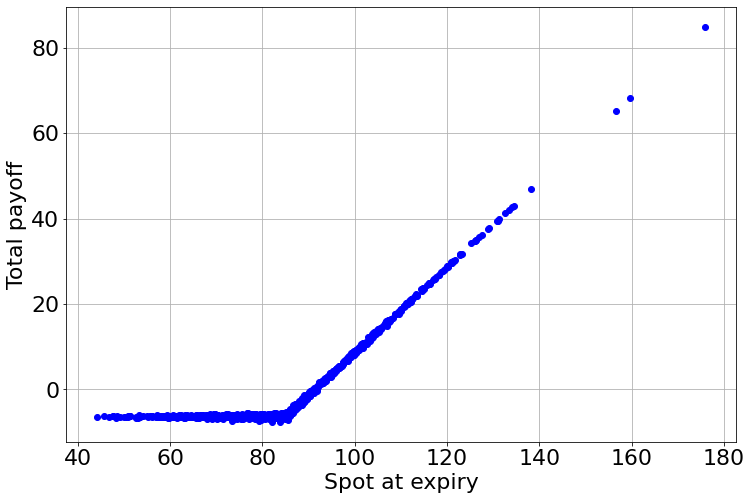

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

lw = 2.5 # line width
fs = 12  # fontsize
picWidth=12; picHeight=8;

matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(picWidth, picHeight))

plt.plot(S, P, 'bo', linewidth=lw)
plt.grid(True)
plt.xlabel('Spot at expiry')
plt.ylabel('Total payoff')

* Не совсем как в лекции. Но и из всех промежуточных вариантов больше всего похоже на правду.

# Задача 3 

Написать функцию для вычисления цены Европейского и Американского опционов в модели CRR (см. обсуждение идеи в лекции).

In [ ]:
import numpy as np

def gen_lattice(S0, u, d, N, dt):
    """generates a binomial lattice
    
    for a given up, down, start value and number of steps (N).
    Resulting lattice has N+1 levels.
    """
    t = [0.]
    S = [float(S0)]

    for i in range(1, N+1):
        for j in range(0, i+1):
            t.append(dt*i)
            S.append( S0 * d**j * u**(i-j) )

    return np.array(t), np.array(S)


def model_params(r, T, sigma, N):
    dt = T / N
    df = np.exp(r * dt)

    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    q = ( np.exp(r * dt) - d ) / (u - d)
    
    return dt, df, u, d, q

from enum import Enum
class CallPut(Enum):
    call = 1
    put = 2

class ExerciseStyle(Enum):
    euro = 1
    amer = 2

In [ ]:
def pv_crr(amerEuro, callPut, S0, K, T, r, sigma, N):
    dt, df, u, d, q = model_params(r, T, sigma, N)
    print(f"df: {df}, u:{u}, d:{d}, q:{q}" )
    _, S = gen_lattice(S0=S0, N=N, u=u, d=d, dt=dt)

    L = N+1

    payoff = lambda x: max( 0, x - K ) if CallPut.call == callPut else max( 0, K - x)

    # Calculate payoff at the last lattice level
    k = len(S)
    for i in range(L):
        k -= 1
        S[k] = payoff(S[k])

    # Go backwards, calculate extected value for prev node, based on known nodes
    # Calculate payoff at node k, based on expected value of S
    for i in range(N-1, -1, -1):
      for j in range(i, -1, -1):
          k -= 1
          if (ExerciseStyle.euro == amerEuro):
              S[k] = (S[k + i + 1] * q + S[k + i + 2] * (1 - q)) * df
          else:
              S[k] = max(payoff(S[k]), S[k + i + 1] * q + S[k + i + 2] * (1 - q)) * df
          
    return S[0], S

In [ ]:
# parameters
S0 = 100.
T = 1.
r = 0.05
sigma = 0.20
K = 100.
N = 1000

es = ExerciseStyle.euro

print("Europian Call/Put")
print("-----------------")
pvC, _ = pv_crr(es, CallPut.call, S0=S0, K=K, T=T, r=r, sigma=sigma, N=N)
print( "PV_Call = ", pvC , "\n")
pvP, _ = pv_crr(es, CallPut.put, S0=S0, K=K, T=T, r=r, sigma=sigma, N=N)
print("PV_Put = ", pvP , "\n \n" )

es = ExerciseStyle.amer

print("American Call/Put")
print("-----------------")
pvC, _ = pv_crr(es, CallPut.call, S0=S0, K=K, T=T, r=r, sigma=sigma, N=N)
print("PV_Call = ", pvC , "\n" )
pvP, _ = pv_crr(es, CallPut.put, S0=S0, K=K, T=T, r=r, sigma=sigma, N=N)
print("PV_Put = ", pvP , "\n" )

Europian Call/Put
-----------------
df: 1.0000500012500209, u:1.00634459755079, d:0.9936954025825434, q:0.5023717859855448
PV_Call =  11.547471286548904 

df: 1.0000500012500209, u:1.00634459755079, d:0.9936954025825434, q:0.5023717859855448
PV_Put =  6.157489116583631 
 

American Call/Put
-----------------
df: 1.0000500012500209, u:1.00634459755079, d:0.9936954025825434, q:0.5023717859855448
PV_Call =  11.547471286548904 

df: 1.0000500012500209, u:1.00634459755079, d:0.9936954025825434, q:0.5023717859855448
PV_Put =  6.451256050201327 



## Europian Call/Put

1)PV_Call =  11.547471286548904

2)PV_Put =  6.157489116583631 


## American Call/Put
3)PV_Call =  11.547471286548904

4)PV_Put =  6.451256050201327
